width: 1653
height: 2338


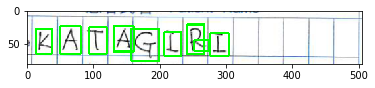

In [11]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

# 依頼書画像から郵便番号領域を抽出する関数
def detect_zipno(fname):
    # 画像を読み込む
    img = cv2.imread(fname)
    # 画像のサイズを求める
    h, w = img.shape[:2]
    print("width: " + str(w))
    print("height: " + str(h))
    # 依頼書画像のカルテ番号のみ抽出する --- (*1)  
    # img = img[0:h//2, w//3:]
    
    # imgの切り出し OpenCV(Python)で画像をトリミング　https://qiita.com/yori1029/items/a0ddd25c9571b28f3e1c
    img = img[620:700,525:1030]
    
    # 画像を二値化 --- (*2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0) 
    im2 = cv2.threshold(gray, 141, 255, cv2.THRESH_BINARY_INV)[1]
    
    # 輪郭を抽出 --- (*3)
    cnts = cv2.findContours(im2, 
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[0]
    
    # 抽出した輪郭を単純なリストに変換--- (*4)
    result = []
    for pt in cnts:
        x, y, w, h = cv2.boundingRect(pt)
        # 大きすぎる小さすぎる領域を除去 --- (*5)
        if not(10< w < 50): continue
        result.append([x, y, w, h])
    # 抽出した輪郭が左側から並ぶようソート --- (*6)
    result = sorted(result, key=lambda x: x[0])
    # 抽出した輪郭が近すぎるものを除去 --- (*7)
    result2 = []
    lastx = -100
    for x, y, w, h in result:
        if (x - lastx) < 1: continue
        result2.append([x, y, w, h])
        lastx = x 
     # 緑色の枠を描画 --- (*8)
    for x, y, w, h in result2:
        cv2.rectangle(img, (x-5, y-5), (x+w+5, y+h+5), (0,255, 0), 2)
    return result2, img

if __name__ == '__main__':
    # ハガキ画像を指定して領域を抽出
    cnts, img = detect_zipno("./trf/31.pdf/trf_2019-07-02_5.png")

    # 画面に抽出結果を描画 --- (*7)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.savefig("Afp4_1-1result.png", dpi=200)
    plt.show()
  

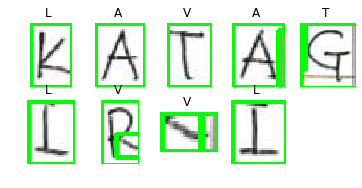

In [12]:
# MLPでMNISTの分類問題に挑戦
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.datasets import mnist
import matplotlib.pyplot as plt

labels = ["A ", "B ", "C ", "D ", "E ", "F ", "G ", "H ", "I ",\
          "J ", "K ", "L ", "M ", "N ", "O ", "P ", "Q ", "R ",\
          "S ", "T ", "U ", "V ", "W ", "X ", "Y ", "Z ",]

# 読み込んだデータをプロット
for i, pt in enumerate(cnts):
    x, y, w, h = pt
  # 枠線の輪郭分だけ小さくする
   # x += 0
    #y += 0
    #w -= 0
    #h -= 0

    # 画像データを取り出す
    im2 = img[y-5:y+h+5, x-5:x+w+5]
    # データを学習済みデータに合わせる
    im2gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) # グレイスケールに
    im2gray = cv2.resize(im2gray, (25, 25)) # リサイズ
    im2gray = 15 - im2gray // 16 # 白黒反転
    #im2gray = cv2.bitwise_not(im2gray) # 白黒反転
    im2gray = im2gray.reshape((-1, 625)) # 一次元に変換
    
    # モデルを読込 --- (*1)
    model = load_model('english_model.h5')
    # 重みデータを読込 --- (*2)
    model.load_weights('english_weight.h5')
   #データ予測する
    res = model.predict(im2gray)
    res2 = res.argmax()
    # 画面に出力
    plt.subplot(3, 5, i + 1)
    plt.imshow(im2)
    plt.axis("off")
    plt.title(labels[res2])

plt.show()